## ML approach to classify patterns in the wheel section

Here we approach a machine learning procedure to study the activity in the wheel section. 

In [1]:
import neurolib as nl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
from matplotlib import cm
from sklearn import cross_validation
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

%pylab inline
# Turn interactive plotting off
plt.ioff()
#plt.rcParams.update({'font.size': 20, 'font.family': 'serif'})

folder = '../HC-5'
names = nl.find_files(folder)

Populating the interactive namespace from numpy and matplotlib
../HC-5/i01_maze05_005/i01_maze05_MS.005_BehavElectrData.mat
../HC-5/i01_maze06_002/i01_maze06_MS.002_BehavElectrData.mat
../HC-5/i01_maze06_005/i01_maze06_MS.005_BehavElectrData.mat
../HC-5/i01_maze08_001/i01_maze08_MS.001_BehavElectrData.mat
../HC-5/i01_maze08_004/i01_maze08_MS.004_BehavElectrData.mat
../HC-5/i01_maze13_003/i01_maze13_MS.003_BehavElectrData.mat
../HC-5/i01_maze15_002/i01_maze15_MS.002_BehavElectrData.mat


In [2]:
animal = 6

## In the case of a section in the maze run this section

In [3]:
data = nl.get_cells(names[animal][1], only_pyr=True, section=['pre_turn', 'lat_arm'], process=False)
spikes = [d.spikes for d in data]
section_name = 'maze'

Available sections of the maze ['wheel', 'pre_turn', 'delay', 'turn', 'mid_arm', 'lat_arm', 'reward']
85 cells extracted
../HC-5/i01_maze15_002/i01_maze15_MS.002_BehavElectrData.mat Loading completed


## In the case of the wheel section run section below

Available sections of the maze ['wheel', 'pre_turn', 'delay', 'turn', 'mid_arm', 'lat_arm', 'reward']
85 cells extracted
../HC-5/i01_maze15_002/i01_maze15_MS.002_BehavElectrData.mat Loading completed


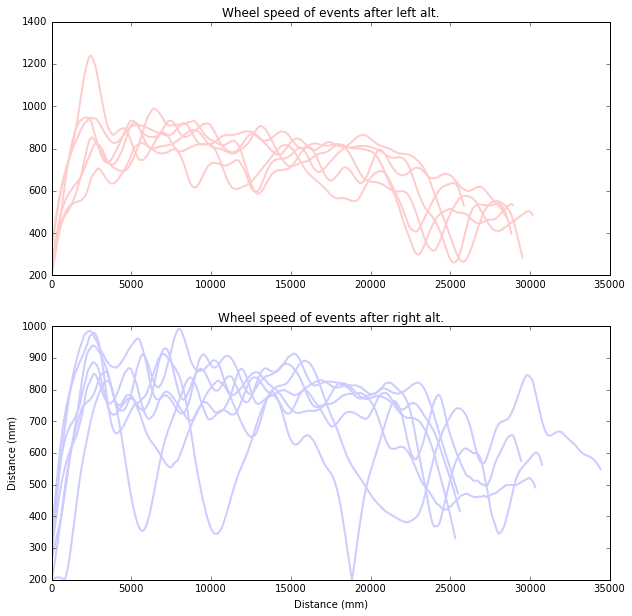

In [ ]:
data = nl.get_cells(names[animal][1], only_pyr=True, section=['wheel', 'wheel'], process=False)
plt.figure(num=None, dpi=150)
f, arr = plt.subplots(2, figsize=(10,10))

section_name = 'wheel'
spikes = [] 

for trial in data:      
    
    non_zero = trial.wheel > 0 
    start = 0
    for i, n in enumerate(non_zero):
        if n is True:
            start = i
            break
            
    if trial.type is 'left':
        arr[0].plot(trial.wheel[non_zero], color=trial.color, linewidth=2)
    if trial.type is 'right':
        arr[1].plot(trial.wheel[non_zero], color=trial.color, linewidth=2)
    
    spike = []
    for s in trial.spikes:
        spike.append(s[s>start])
        
    spikes.append(spike)
        

plt.xlabel('Distance (mm)')
arr[0].set_title('Wheel speed of events after left alt.')
arr[1].set_title('Wheel speed of events after right alt.')
plt.ylabel('Distance (mm)')
plt.show()

## The cell below shows the spikes per lap for control purposes: no need to run (time consuming)

In [ ]:
cmap = cm.get_cmap(name='rainbow')

for lap in spikes:    
    plt.figure(num=None, dpi=150, figsize=(10,10))       
    for j, counts in enumerate(lap):
        for s in counts:            
            plt.plot([s, s], [j, j+0.5], linewidth=2, color=cmap(j))
            plt.title('Spikes in lap {}'.format(j))
            
plt.show()

In [ ]:
# segmentar every 20 ms
max_time = 3.*1250. if section_name is 'maze' else 10.*1250 # seconds * sampling frequency
n_bins = max_time/(0.02*1250)
bins = np.linspace(0, max_time, n_bins)

spike_count = []
for lap in spikes:
    count = []
    for cell in lap:
        hist,_ = np.histogram(cell, bins)
        count.append(hist)
    spike_count.append(count)

mean_count_left = np.zeros([data[0].n_cells, n_bins-1])
mean_count_right= np.zeros([data[0].n_cells, n_bins-1])
for trial, s_count in zip(data, spike_count):
    if trial.type is 'right':
        mean_count_left = s_count
    if trial.type is 'left':
        mean_count_right += s_count

In [ ]:
plt.figure(num=None, dpi=150, figsize=(17,4))       
plt.imshow(mean_count_left)
plt.xlabel('Bins')
plt.ylabel('Cell #')
plt.title(section_name + ' left alt.')
plt.show()

plt.figure(num=None, dpi=150, figsize=(17,4))       
plt.imshow(mean_count_right)
plt.ylabel('Cell #')
plt.ylabel('Neuron')
plt.title(section_name + ' right alt.')
plt.show()

In [ ]:
cell_response_per_bin = np.mean(mean_count_right,axis=1)
cell_response_per_bin_left = np.mean(mean_count_left,axis=1)

plt.figure(num=None, dpi=150, figsize=(5,5))       
plt.plot(cell_response_per_bin, 'red',label='right alt.')
plt.plot(cell_response_per_bin_left, 'blue',label='left alt.')
plt.xlabel('Cell #')
plt.ylabel('Average spike count')
plt.title(section_name)
plt.legend()
plt.show()

Lets train a classifier with the first 10 cells which seems to be discriminative enough.

In [ ]:
ten_cells_left = mean_count_left[:][:]
ten_cells = mean_count_right[:][:]

labels = np.ones(len(ten_cells[0]) + len(ten_cells_left[0]))
labels[len(ten_cells[0]):] = 0

data = np.transpose(np.concatenate((ten_cells, ten_cells_left), axis=1))

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, labels, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

scores = cross_validation.cross_val_score(clf, data, labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f) with %d cells" % (scores.mean(), scores.std() * 2, len(ten_cells)))

# All animals wheel section

In [ ]:
rates = []
for a in names:
    print('Proceesing %s'%(a[0]))
    data = nl.get_cells(a[1], only_pyr=True, section=['pre_turn', 'lat_arm'], process=False)
    spikes = [d.spikes for d in data]
    section_name = 'maze'
    
    # segmentar every 20 ms
    max_time = 3.*1250. if section_name is 'maze' else 10.*1250 # seconds * sampling frequency
    n_bins = max_time/(0.02*1250)
    bins = np.linspace(0, max_time, n_bins)

    spike_count = []
    for lap in spikes:
        count = []
        for cell in lap:
            hist,_ = np.histogram(cell, bins)
            count.append(hist)
        spike_count.append(count)

    mean_count_left = np.zeros([data[0].n_cells, n_bins-1])
    mean_count_right= np.zeros([data[0].n_cells, n_bins-1])
    for trial, s_count in zip(data, spike_count):
        if trial.type is 'right':
            mean_count_left = s_count
        if trial.type is 'left':
            mean_count_right += s_count 
            
    cell_response_per_bin = np.mean(mean_count_right,axis=1)
    cell_response_per_bin_left = np.mean(mean_count_left,axis=1)
    
    ten_cells_left = mean_count_left[:][:]
    ten_cells = mean_count_right[:][:]

    labels = np.ones(len(ten_cells[0]) + len(ten_cells_left[0]))
    labels[len(ten_cells[0]):] = 0

    data = np.transpose(np.concatenate((ten_cells, ten_cells_left), axis=1))

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, labels, test_size=0.4, random_state=0)
    
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    #Naive Bayes
    gnb = GaussianNB()
    clf_nb = gnb.fit(X_train, y_train)
    
    scores = cross_validation.cross_val_score(clf, data, labels, cv=5)
    scores_nb = cross_validation.cross_val_score(clf_nb, data, labels, cv=5)

    print("Accuracy SVM: %0.2f (+/- %0.2f) with %d cells" % (scores.mean(), scores.std() * 2, len(ten_cells)))
    rates.append(scores)
    print("Accuracy NB: %0.2f (+/- %0.2f) with %d cells" % (scores_nb.mean(), scores_nb.std() * 2, len(ten_cells)))
    rates.append(scores_nb)

In [ ]:
rXY = np.array([(s.mean(), s.std() * 2) for s in rates])
x = np.linspace(0,6, len(rXY))

rats = [a[0] for a in names]

plt.figure(figsize = (7,6))
plt.errorbar(x, rXY[:,0], yerr=rXY[:,1], fmt='--o', lw=2)
plt.xlabel('Animal')
plt.ylabel('Cross validated Class. Acc ($mu\pm\sigma$)')
plt.title('Left/right wheel class.with linear SVM')
ax = plt.gca()
ax.set_xticklabels(rats,rotation=40)
plt.xlim([-1, 7])
plt.ylim([0, 1.5])
plt.grid()
plt.show()